
# TOF listmode OSEM with projection data

This example demonstrates the use of the listmode OSEM algorithm to minimize the negative Poisson log-likelihood function.

\begin{align}f(x) = \sum_{i=1}^m \bar{y}_i (x) - \bar{y}_i (x) \log(y_i)\end{align}

subject to

\begin{align}x \geq 0\end{align}

using the listmode linear forward model

\begin{align}\bar{y}_{LM}(x) = A_{LM} x + s\end{align}

and data stored in listmode format (event by event).

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [1]:
from __future__ import annotations
from array_api_strict._array_object import Array

# import array_api_compat.numpy as xp

import array_api_compat.cupy as xp
# import array_api_compat.torch as xp

import parallelproj
from array_api_compat import to_device, size
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    if parallelproj.cuda_present:
        dev = "cuda"
    else:
        dev = "cpu"


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /home/pablo/anaconda3/envs/recon/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /home/pablo/anaconda3/envs/recon/lib/libparallelproj_cuda.so.1.8.0
    


## Simulation of PET data in sinogram space

In this example, we use simulated listmode data for which we first
need to setup a sinogram forward model to create a noise-free and noisy
emission sinogram that can be converted to listmode data.



### Setup of the sinogram forward model

We setup a linear forward operator $A$ consisting of an
image-based resolution model, a non-TOF PET projector and an attenuation model




In [2]:
num_rings = 40
radius = 65.0
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=radius,
    num_sides=180,
    num_lor_endpoints_per_side=1,
    lor_spacing=2.3,
    ring_positions=xp.linspace(-10, 10, num_rings),
    symmetry_axis=2,
)

# setup the LOR descriptor that defines the sinogram

img_shape = (40, 40, 8)
voxel_size = (2.0, 2.0, 2.0)

lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=10,
    max_ring_difference=79,
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)

proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=img_shape, voxel_size=voxel_size
)

# setup a simple test image containing a few "hot rods"
x_true = xp.ones(proj.in_shape, device=dev, dtype=xp.float32)
c0 = proj.in_shape[0] // 2
c1 = proj.in_shape[1] // 2
x_true[(c0 - 2) : (c0 + 2), (c1 - 2) : (c1 + 2), :] = 5.0
x_true[4, c1, 4:] = 5.0
x_true[c0, 4, 4:] = 5.0

x_true[:2, :, :] = 0
x_true[-2:, :, :] = 0
x_true[:, :2, :] = 0
x_true[:, -2:, :] = 0
print(c0, c1, x_true.shape)

20 20 (40, 40, 8)


### Attenuation image and sinogram setup



In [3]:
# # setup an attenuation image
# x_att = 0.01 * xp.astype(x_true > 0, xp.float32)
# # calculate the attenuation sinogram
# att_sino = xp.exp(-proj(x_att))

### Complete sinogram PET forward model setup

We combine an image-based resolution model,
a non-TOF or TOF PET projector and an attenuation model
into a single linear operator.



In [4]:
# enable TOF - comment if you want to run non-TOF
sigma_tof =12.0
proj.tof_parameters = parallelproj.TOFParameters(
    num_tofbins=13, tofbin_width=12.0, sigma_tof=sigma_tof
)

TOFps = sigma_tof * 2.355 / 1e-12 / 3e8 / 1e3 * 2
print("TOFps", TOFps)

# TOFps = 225
# tofbin_FWHM = TOFps * 1e-12 * 3e8 / 2 *1e3 # *1e3 to mm;  *1e-12 to s; *3e8 to m/s;  /2 to get one-way distance;
# sigma_tof = tofbin_FWHM / 2.355 # / 2.355 to get sigma from FWHM
# tofbin_width = 1.03 * sigma_tof  # as given in https://parallelproj.readthedocs.io/en/stable/python_api.html#module-parallelproj.tof
# num_tofbins = int(2 * 2 * np.sqrt(radius**2 + 10**2) // tofbin_width)
# if num_tofbins % 2 == 0:
#     num_tofbins -= 1
# print("num_tofbins", num_tofbins)
# # setup TOF parameters with a TOF resolution FWHM = 30mm (ca 200ps)
# tof_params = parallelproj.TOFParameters(
#     sigma_tof=sigma_tof, num_tofbins=num_tofbins, tofbin_width=tofbin_width
# )
# proj.tof_parameters = tof_params

res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=0.0 / (2.35 * proj.voxel_size)
)

# compose all 3 operators into a single linear operator
# pet_lin_op = parallelproj.CompositeLinearOperator((att_op, proj, res_model))
pet_lin_op = parallelproj.CompositeLinearOperator((proj, res_model))

TOFps 188.4


### Simulation of sinogram projection data

We setup an arbitrary ground truth $x_{true}$ and simulate
noise-free and noisy data $y$ by adding Poisson noise.



In [5]:
# # simulated noise-free data
# noise_free_data = pet_lin_op(x_true)

# # generate a contant contamination sinogram
# contamination = xp.full(
#     noise_free_data.shape,
#     0.5 * float(xp.mean(noise_free_data)),
#     device=dev,
#     dtype=xp.float32,
# )

# noise_free_data += contamination

# # add Poisson noise
# np.random.seed(1)
# y = xp.asarray(
#     np.random.poisson(parallelproj.to_numpy_array(noise_free_data)),
#     device=dev,
#     dtype=xp.int16,
# )

### Conversion of the emission sinogram to listmode

Using :meth:`.RegularPolygonPETProjector.convert_sinogram_to_listmode` we can convert an
integer non-TOF or TOF sinogram to an event list for listmode processing.

**Note:** The create event list is sorted and should be shuffled running LM-MLEM.



In [6]:
# event_start_coords, event_end_coords, event_tofbins = proj.convert_sinogram_to_listmode(
#     y
# )
# print(event_end_coords[:, 0].max(), event_end_coords[:, 1].max(), event_end_coords[:, 2].max())
# print(event_end_coords[:, 0].min(), event_end_coords[:, 1].min(), event_end_coords[:, 2].min())

In [7]:
### Loading psf (listmode data)
import struct
import pandas as pd
psf_path = '/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/parallelproj_sample_simulation/MCGPU_PET.psf.raw'

# Define the path to your binary .raw file
binary_file_path = psf_path

# Open and read the binary file
with open(binary_file_path, 'rb') as file:
    # Define the structure format for one data record based on the given specification:
    # 'Q' -> unsigned long long int (emission_time (ps))
    # 'f' -> float (travel_time (ps))
    # 'i' -> int (emission voxel)
    # 'f' -> float (energy)
    # 'f' -> float (z (cm))
    # 'f' -> float (phi (rad))
    # 'f' -> float (vx; x component of the incident photon direction)
    # vx = (x2 - x1) / sqrt((x2 - x1)^2 + (y2 - y1)^2 + (z2 - z1)^2), x1,2 = r * cos(phi1,2), y1,2 = r * sin(phi1,2)
    # 'f' -> float (vy; y component of the incident photon direction)
    # 'f' -> float (vz; z component of the incident photon direction) 
    # 'h' -> short int (index1) (Flag for scatter: =0 for non-scattered, =1 for Compton, =2 for Rayleigh, and =3 for multiple scatter)
    # 'h' -> short int (index2)
    format_string = 'Q f i f f f f f f h h'
    record_size = struct.calcsize(format_string)
    
    # Read all records (adjust the count if needed)
    data = file.read()

    # Calculate the number of records
    num_records = len(data) // record_size

    # Unpack all records
    records = []
    for i in range(num_records):
        record_data = data[i*record_size:(i+1)*record_size]
        record = struct.unpack(format_string, record_data)
        records.append(record)

# Print the first 5 records as an example
for record in records[:5]:
    print(record)
    
columns = [
    'emission_time', 'travel_time', 'emission_voxel', 'energy',
    'z', 'phi', 'vx', 'vy', 'vz', 'index1', 'index2'
]

events = pd.DataFrame(records, columns=columns)
del records
events = events.drop(columns=['vx', 'vy', 'vz', 'emission_voxel', 'index2'])

(5233139513779, 126.78181457519531, 245, 527602.4375, -0.8053868412971497, -1.8069343566894531, 0.374250590801239, -0.9265689849853516, -0.037500202655792236, 0, 0)
(5233139513779, 153.2188262939453, 245, 419165.90625, -0.16696695983409882, -3.1406772136688232, -0.8029423356056213, 0.5851433277130127, 0.11353801935911179, 1, 0)
(5059809505473, 95.56725311279297, 245, 515250.34375, -0.9481937289237976, -2.6836001873016357, -0.9929090142250061, -0.08229957520961761, -0.08578140288591385, 0, 0)
(5059809505473, 309.4801330566406, 245, 543163.4375, 0.08262317627668381, -0.2909216284751892, 0.9929177165031433, 0.08339580148458481, 0.0846143364906311, 0, 0)
(884658948014, 125.3257064819336, 242, 487598.3125, -0.5596237182617188, -1.9061907529830933, 0.3688582479953766, -0.9282881021499634, 0.047166287899017334, 0, 0)


In [8]:
# Display the first few rows of the DataFrame
events['x'] = radius * np.cos(events.phi)  # x position of the detector
events['y'] = radius * np.sin(events.phi)  # y position of the detector
events['z'] = events['z'] * 10.0  # cm to mm
distances = np.sqrt(((events[['x', 'y', 'z']].iloc[1::2].values - events[['x', 'y', 'z']].iloc[0::2].values)**2).sum(axis=1))  # to mm
distances = np.repeat(distances, 2) # calculate distances between detectors from the detector positions
events['distance'] = distances
distances = 3e8 * (events['travel_time'].iloc[1::2].values + events['travel_time'].iloc[0::2].values) * 1e-12 * 1000  # 1e-12 because of ps, 1000 because of mm
distances = np.repeat(distances, 2) # calculate distances between detectors from the travel times
events['distance2'] = distances

TOF_resolution = TOFps  # ps, it is the minimum time difference between the arrival of two photons that it can detect. it is diveded by 2 because if one of them arrivs TOF_resolution
bin = np.round((events['travel_time'].iloc[0::2].values - events['travel_time'].iloc[1::2].values) / TOF_resolution).astype(int)
bin = np.repeat(bin, 2)
events['bin'] = bin
print(events.head())
event_start_coordinates = xp.asarray(events[['y', 'x', 'z']].iloc[0::2].values, device=dev)  # switching z and y to match paralleproj convention
event_end_coordinates = xp.asarray(events[['y', 'x', 'z']].iloc[1::2].values, device=dev) 

event_tof_bins = xp.asarray(events['bin'].iloc[0::2].values, device=dev)

   emission_time  travel_time        energy         z       phi  index1  \
0  5233139513779   126.781815  527602.43750 -8.053868 -1.806934       0   
1  5233139513779   153.218826  419165.90625 -1.669670 -3.140677       1   
2  5059809505473    95.567253  515250.34375 -9.481937 -2.683600       0   
3  5059809505473   309.480133  543163.43750  0.826232 -0.290922       0   
4   884658948014   125.325706  487598.31250 -5.596237 -1.906191       0   

           x          y    distance   distance2  bin  
0 -15.206723 -63.196167   80.662036   84.000192    0  
1 -64.999973  -0.059504   80.662036   84.000192    0  
2 -58.301226 -28.739643  121.430146  121.514216   -1  
3  62.268695 -18.644291  121.430146  121.514216   -1  
4 -21.394207 -61.378236   98.523569   98.593769    0  


In [9]:
# count unique values in event_tofbins and number of events for each unique value
unique_tofbins, num_events = xp.unique(event_tof_bins, return_counts=True)
print("Unique TOF bins: ", unique_tofbins)
print("Number of events in each TOF bin: ", num_events)

Unique TOF bins:  [-2 -1  0]
Number of events in each TOF bin:  [   73  5993 63819]


## Setup of the LM subset projectors and LM subset forward models



In [10]:
num_subsets = 10
subset_slices = [slice(i, None, num_subsets) for i in range(num_subsets)]

lm_pet_subset_linop_seq = []

for i, sl in enumerate(subset_slices):
    subset_lm_proj = parallelproj.ListmodePETProjector(
        event_start_coordinates[sl, :],
        event_end_coordinates[sl, :],
        proj.in_shape,
        proj.voxel_size,
        proj.img_origin,
    )

    # recalculate the attenuation factor for all LM events
    # this needs to be a non-TOF projection
    # subset_att_list = xp.exp(-subset_lm_proj(x_att))

    # enable TOF in the LM projector
    subset_lm_proj.tof_parameters = proj.tof_parameters
    if proj.tof:
        # we need to make a copy of the 1D subset event_tofbins array
        # stupid way of doing this, but torch asarray copy doesn't seem to work
        subset_lm_proj.event_tofbins = 1 * event_tof_bins[sl]
        subset_lm_proj.tof = proj.tof

    # subset_lm_att_op = parallelproj.ElementwiseMultiplicationOperator(subset_att_list)

    lm_pet_subset_linop_seq.append(
        parallelproj.CompositeLinearOperator(
            # (subset_lm_att_op, subset_lm_proj, res_model)
            (subset_lm_proj, res_model)
        )
    )

lm_pet_subset_linop_seq = parallelproj.LinearOperatorSequence(lm_pet_subset_linop_seq)

# # create the contamination list
# contamination_list = xp.full(
#     event_start_coords.shape[0],
#     float(xp.reshape(contamination, (size(contamination),))[0]),
#     device=dev,
#     dtype=xp.float32,
# )

## LM OSEM reconstruction

The EM update that can be used in LM-OSEM is given by

\begin{align}x^+ = \frac{x}{(A^k)^H 1} (A_{LM}^k)^H \frac{1}{A_{LM}^k x + s_{LM}^k}\end{align}

to calculate the minimizer of $f(x)$ iteratively.



In [11]:
def lm_em_update(
    x_cur: Array,
    op: parallelproj.LinearOperator,
    # s: Array,
    adjoint_ones: Array,
) -> Array:
    """LM EM update

    Parameters
    ----------
    x_cur : Array
        current solution
    op : parallelproj.LinearOperator
        subset listmode linear forward operator
    s : Array
        subset contamination list
    adjoint_ones : Array
        adjoint of ones of the non-LM (the complete) operator
        divided by the number of subsets

    Returns
    -------
    Array
        _description_
    """
    ybar = op(x_cur)
    x = x_cur * op.adjoint(1 / (1e-10 + ybar)) / adjoint_ones
    return x

## Run LM OSEM iterations



In [12]:
# number of MLEM iterations
num_iter = 50 // num_subsets

# initialize x
x = xp.ones(img_shape, dtype=xp.float32, device=dev)
# calculate A^H 1
adjoint_ones = proj.adjoint(
    xp.ones(proj.out_shape, dtype=xp.float32, device=dev)
)
print(adjoint_ones.shape)

for i in range(num_iter):
    for k, sl in enumerate(subset_slices):
        print(f"OSEM iteration {(k+1):03} / {(i + 1):03} / {num_iter:03}", end="\r")
        x = lm_em_update(
            x,
            lm_pet_subset_linop_seq[k],
            # contamination_list[sl],
            adjoint_ones / num_subsets,
        )

(40, 40, 8)


## Calculate the negative Poisson log-likelihood function of the reconstruction



In [13]:
# calculate the negative Poisson log-likelihood function of the reconstruction
exp = pet_lin_op(x)
# # calculate the relative cost and distance to the optimal point
# cost = float(xp.sum(exp - xp.astype(y, xp.float32) * xp.log(exp)))
# print(
#     f"\nLM-OSEM cost {cost:.6E} after {num_iter:03} iterations with {num_subsets} subsets"
# )

## Visualize the results



(40, 40, 8)


/tmp/ipykernel_228982/2374642910.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


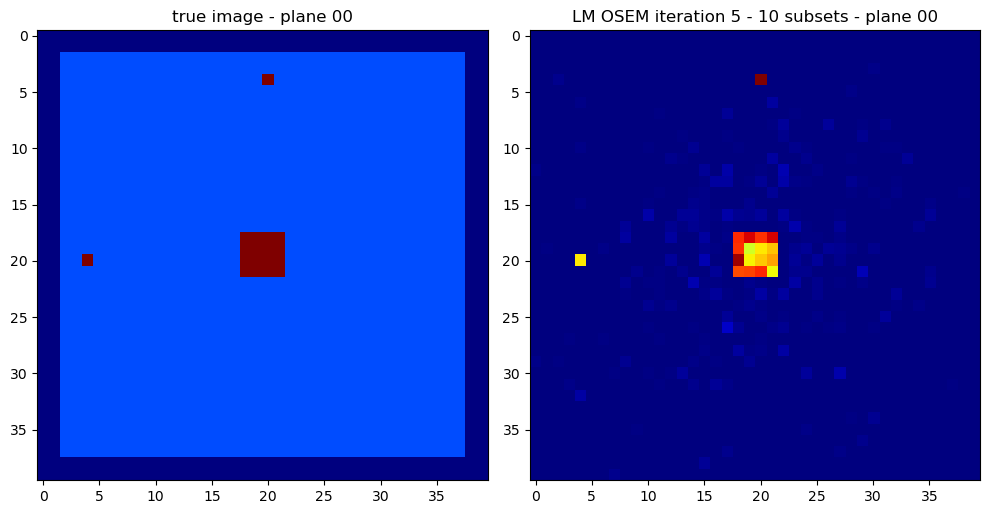

In [14]:
def _update_img(i):
    img0.set_data(x_true_np[:, :, i])
    img1.set_data(x_np[:, :, i])
    ax[0].set_title(f"true image - plane {i:02}")
    ax[1].set_title(
        f"LM OSEM iteration {num_iter} - {num_subsets} subsets - plane {i:02}"
    )
    return (img0, img1)

print(x_true.shape)


x_true_np = parallelproj.to_numpy_array(x_true)
x_np = parallelproj.to_numpy_array(x)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vmax = x_np.max()
img0 = ax[0].imshow(x_true_np[:, :, 4], cmap="jet")
img1 = ax[1].imshow(x_np[:, :, 4], cmap="jet")
ax[0].set_title(f"true image - plane {0:02}")
ax[1].set_title(f"LM OSEM iteration {num_iter} - {num_subsets} subsets - plane {0:02}")
fig.tight_layout()
# ani = animation.FuncAnimation(fig, _update_img, x_np.shape[2], interval=200, blit=False)
fig.show()

In [15]:
mse = np.mean((x_true_np - x_np) ** 2)
print(f"Mean squared error: {mse:.6E}")

Mean squared error: 1.064236E+00


In [16]:
1.040372E+00

1.040372